In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

In [2]:
from google.colab import drive # untuk menghubungkan ke dalam drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
jambuBiji = os.listdir('/content/drive/MyDrive/JambuBiji/') 
sirih = os.listdir('/content/drive/MyDrive/Sirih/')

In [4]:
data = []
labels = []

for i in jambuBiji:
    try:
    
        image = cv2.imread("/content/drive/MyDrive/JambuBiji/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
        
    except AttributeError:
        print('')
    
for u in sirih:
    try:
        
        image = cv2.imread("/content/drive/MyDrive/Sirih/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        labels.append(0)
        labels.append(0)
        labels.append(0)
        
    except AttributeError:
        print('')

In [5]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

In [6]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))

Cells : (350, 50, 50, 3) | labels : (350,)


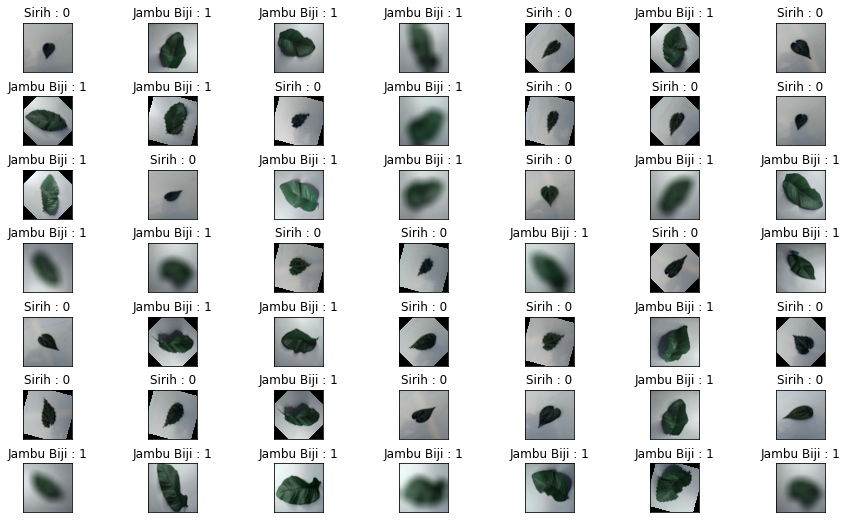

In [7]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Jambu Biji' if labels[r[0]] == 1 else 'Sirih' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

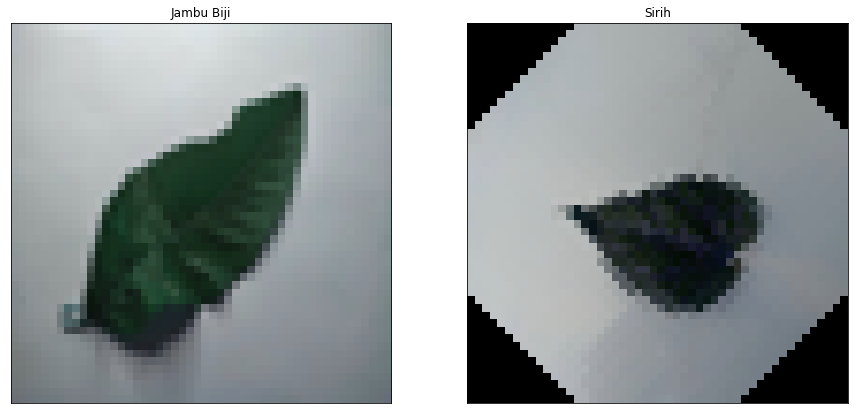

In [10]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[0])
plt.title('Jambu Biji')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[276])
plt.title('Sirih')
plt.xticks([]) , plt.yticks([])

plt.show()

In [11]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [12]:
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

In [13]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , 
                                            test_size = 0.4 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.4 , 
                                                    random_state = 111)

In [14]:
print('train data shape {} ,eval data shape {} , test data shape {}'.format(train_x.shape,
                                                                           eval_x.shape ,
                                                                           test_x.shape))

train data shape (210, 50, 50, 3) ,eval data shape (84, 50, 50, 3) , test data shape (56, 50, 50, 3)


In [15]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, GlobalMaxPool2D, Conv2D, MaxPool2D, Flatten


# Feature Extraction Layer
model1 = Sequential()
model1.add(InputLayer(input_shape = [50,50,3]))

model1.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(MaxPool2D(pool_size=2, padding='same'))
model1.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(MaxPool2D(pool_size=2, padding='same'))
model1.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(MaxPool2D(pool_size=2, padding='same'))

model1.add(GlobalMaxPool2D())
model1.add(Flatten())

# Fully Connected Layer

model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# Summary Scenario Pertama

print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0

In [16]:
from tensorflow.keras.optimizers import Adam

model1.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
Sc1 = model1.fit(test_x, test_y, batch_size=32, epochs=25, validation_data=(test_x, test_y))

Epoch 1/25
2/2 [==============================] - 1s 297ms/step - loss: 0.6897 - acc: 0.5000 - val_loss: 0.6722 - val_acc: 0.6071
Epoch 2/25
2/2 [==============================] - 0s 128ms/step - loss: 0.6716 - acc: 0.6071 - val_loss: 0.6587 - val_acc: 0.6071
Epoch 3/25
2/2 [==============================] - 0s 121ms/step - loss: 0.6580 - acc: 0.6071 - val_loss: 0.6523 - val_acc: 0.6071
Epoch 4/25
2/2 [==============================] - 0s 124ms/step - loss: 0.6528 - acc: 0.6071 - val_loss: 0.6494 - val_acc: 0.6071
Epoch 5/25
2/2 [==============================] - 0s 136ms/step - loss: 0.6489 - acc: 0.6071 - val_loss: 0.6450 - val_acc: 0.6071
Epoch 6/25
2/2 [==============================] - 0s 125ms/step - loss: 0.6439 - acc: 0.6071 - val_loss: 0.6389 - val_acc: 0.6071
Epoch 7/25
2/2 [==============================] - 0s 123ms/step - loss: 0.6374 - acc: 0.6071 - val_loss: 0.6329 - val_acc: 0.6071
Epoch 8/25
2/2 [==============================] - 0s 117ms/step - loss: 0.6317 - acc: 0.60

In [18]:
from sklearn.metrics import classification_report

pred = model1.predict(eval_x)
labels = (pred > 0.5).astype(np.int)

print(classification_report(eval_y, labels))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        34
           1       0.96      1.00      0.98        50

    accuracy                           0.98        84
   macro avg       0.98      0.97      0.98        84
weighted avg       0.98      0.98      0.98        84



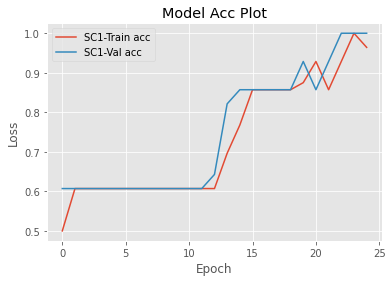

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,25), Sc1.history["acc"], label="SC1-Train acc")
plt.plot(np.arange(0,25), Sc1.history["val_acc"], label="SC1-Val acc")
plt.title("Model Acc Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()